# Explore candidates matched to DESI spectra

A suggestion from Peter Nugent

## Set up

Import packages and define plotting parameters.

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import astropy.units as u
from astropy.table import unique
from astropy.timeseries import LombScargle

In [2]:
all_filters = np.asarray(['g','r','i'], dtype='str')
all_fcolors = np.asarray(['green','red','blue'], dtype='str')
all_fshapes = np.asarray(['o','s','^'], dtype='str')
all_fsizes  = np.asarray([5, 5, 7], dtype='int')

### Read DECam DDF data

Read in the nightly-epoch light curves and their measured parameters.

In [3]:
fnm = '../all_nightly_epochs_files/candidate_lightcurves.dat'
candLC_field = np.loadtxt(fnm, dtype='str', usecols=(0))
candLC_candid = np.loadtxt(fnm, dtype='str', usecols=(1))
candLC_caldate = np.loadtxt(fnm, dtype='str', usecols=(2))
candLC_mjd = np.loadtxt(fnm, dtype='float', usecols=(3))
candLC_filter = np.loadtxt(fnm, dtype='str', usecols=(4))
candLC_Nobj = np.loadtxt(fnm, dtype='int', usecols=(5))
candLC_mag = np.loadtxt(fnm, dtype='float', usecols=(6))
candLC_mage = np.loadtxt(fnm, dtype='float', usecols=(7))
candLC_mrb = np.loadtxt(fnm, dtype='float', usecols=(8))
candLC_lef = np.loadtxt(fnm, dtype='float', usecols=(9))
del fnm

In [4]:
fnm = '../all_nightly_epochs_files/candidate_lightcurve_parameters.dat'
paramLC_field = np.loadtxt(fnm, dtype='str', usecols=(0))
paramLC_candid = np.loadtxt(fnm, dtype='str', usecols=(1))
paramLC_tspan = np.loadtxt(fnm, dtype='float', usecols=(2))
paramLC_tspan_g = np.loadtxt(fnm, dtype='float', usecols=(3))
paramLC_tspan_r = np.loadtxt(fnm, dtype='float', usecols=(4))
paramLC_tspan_i = np.loadtxt(fnm, dtype='float', usecols=(5))
paramLC_minmag = np.loadtxt(fnm, dtype='float', usecols=(6))
paramLC_minmag_g = np.loadtxt(fnm, dtype='float', usecols=(7))
paramLC_minmag_r = np.loadtxt(fnm, dtype='float', usecols=(8))
paramLC_minmag_i = np.loadtxt(fnm, dtype='float', usecols=(9))
paramLC_amp = np.loadtxt(fnm, dtype='float', usecols=(10))
paramLC_amp_g = np.loadtxt(fnm, dtype='float', usecols=(11))
paramLC_amp_r = np.loadtxt(fnm, dtype='float', usecols=(12))
paramLC_amp_i = np.loadtxt(fnm, dtype='float', usecols=(13))
paramLC_neps = np.loadtxt(fnm, dtype='int', usecols=(14))
paramLC_neps_g = np.loadtxt(fnm, dtype='int', usecols=(15))
paramLC_neps_r = np.loadtxt(fnm, dtype='int', usecols=(16))
paramLC_neps_i = np.loadtxt(fnm, dtype='int', usecols=(17))
del fnm

Nightly-epoch magnitude limits, so we have a list of all epochs.

In [5]:
fnm = '../all_nightly_epochs_files/nightly_epoch_magnitude_limits.dat'
neml_field = np.loadtxt(fnm, dtype='str', usecols=(0))
neml_caldate = np.loadtxt(fnm, dtype='str', usecols=(1))
neml_mjd = np.loadtxt(fnm, dtype='float', usecols=(2))
neml_filter = np.loadtxt(fnm, dtype='str', usecols=(3))
neml_nimgs = np.loadtxt(fnm, dtype='int', usecols=(4))
neml_limmag = np.loadtxt(fnm, dtype='float', usecols=(5))
neml_limmage = np.loadtxt(fnm, dtype='float', usecols=(6))
del fnm

In [6]:
for field in ['COSMOS', 'ELAIS']:
    gx = np.where((neml_field == field) & (neml_filter == 'g'))[0]
    rx = np.where((neml_field == field) & (neml_filter == 'r'))[0]
    ix = np.where((neml_field == field) & (neml_filter == 'i'))[0]
    print(len(gx), len(rx), len(ix))
    del gx, rx, ix

80 80 84
97 97 96


### Read cross-match to legacy survey

Read in all rows of the cross-matched file.

`flagstar` : 1 if matched to a star; 0 if matched to a galaxy; -1 if unmatched (int) 

`flagcore` : 1 if matched to the core of the galaxy; 0 otherwise (int) 

`flagmatch` : 1 if a star AND galaxy met constraints; 0 if one or the other; -1 if unmatched (int) 

In [7]:
fnm = '../cross_matched_LSDR10/candidate_xmatch_LSdr10.dat'
lsdr10xm_candid   = np.loadtxt(fnm, dtype='str', usecols=(0))
lsdr10xm_candra   = np.loadtxt(fnm, dtype='float', usecols=(1))
lsdr10xm_canddec  = np.loadtxt(fnm, dtype='float', usecols=(2))
lsdr10xm_flagstar = np.loadtxt(fnm, dtype='int', usecols=(4))
lsdr10xm_flagcore = np.loadtxt(fnm, dtype='int', usecols=(5))
lsdr10xm_flagmatch= np.loadtxt(fnm, dtype='int', usecols=(6))
lsdr10xm_sep      = np.loadtxt(fnm, dtype='float', usecols=(7))
lsdr10xm_ra       = np.loadtxt(fnm, dtype='float', usecols=(8))
lsdr10xm_dec      = np.loadtxt(fnm, dtype='float', usecols=(9))
lsdr10xm_rmag     = np.loadtxt(fnm, dtype='float', usecols=(13))
lsdr10xm_type     = np.loadtxt(fnm, dtype='str', usecols=(15))
lsdr10xm_shaper   = np.loadtxt(fnm, dtype='float', usecols=(19))
lsdr10xm_rpsfsize = np.loadtxt(fnm, dtype='float', usecols=(21))  
lsdr10xm_meanpz   = np.loadtxt(fnm, dtype='float', usecols=(23))
lsdr10xm_stdpz    = np.loadtxt(fnm, dtype='float', usecols=(24))
lsdr10xm_specz    = np.loadtxt(fnm, dtype='float', usecols=(25))
del fnm

In [8]:
fnm = '../cross_matched_LSDR10/candidate_links.dat'
links_candid = np.loadtxt(fnm, dtype='str', usecols=(0))
links_lsview = np.loadtxt(fnm, dtype='str', usecols=(1))
links_rkpage = np.loadtxt(fnm, dtype='str', usecols=(2))

Cross-match between the `lsdr10xm_` arrays and `paramLC_` arrays.

In [9]:
paramLC_xindex = np.zeros(len(paramLC_candid), dtype='int') - 1
lsdr10xm_pindex = np.zeros(len(lsdr10xm_candid), dtype='int') -1

for px in range(len(paramLC_candid)):
    tx = np.where(paramLC_candid[px] == lsdr10xm_candid)[0]
    if len(tx) == 1:
        paramLC_xindex[px] = tx[0]
        lsdr10xm_pindex[tx[0]] = px
    else:
        print(paramLC_candid[px], len(tx))
    del tx
del px

Reminder of how many candidates are matched to stars vs. galaxies.

In [10]:
sx = np.where(lsdr10xm_flagstar == 1)[0]
gx = np.where(lsdr10xm_flagstar == 0)[0]
print('Number of candidates matched to:')
print('stars: ', len(sx))
print('galaxies: ', len(gx))
del sx, gx

Number of candidates matched to:
stars:  1081
galaxies:  802


### Read Peter's file

CSV

Name, RA, Dec, z, z_err, Type

In [11]:
desi_cand = np.loadtxt('clean_mg.dat', dtype='str', delimiter=',', usecols=(0))
desi_z = np.loadtxt('clean_mg.dat', dtype='float', delimiter=',', usecols=(3))
desi_ze = np.loadtxt('clean_mg.dat', dtype='float', delimiter=',', usecols=(4))
desi_type = np.loadtxt('clean_mg.dat', dtype='str', delimiter=',', usecols=(5))

How many objects and what are their DESI-classified types?

In [12]:
print(len(desi_cand))

578


In [13]:
# values, counts = np.unique(desi_type, return_counts=True)
# for value, count in zip(values, counts):
#     print(value, count)
# del values, counts

In [14]:
temp = []
for dtype in desi_type:
    temp.append(dtype[1:4])
desi_stype = np.asarray(temp, dtype='str')
del temp

In [15]:
values, counts = np.unique(desi_stype, return_counts=True)
for value, count in zip(values, counts):
    print(value, count)
del values, counts

GAL 131
QSO 432
STA 15


Make arrays to index between the `desi` and `paramLC` arrays.

In [16]:
desi_pindex = np.zeros(len(desi_cand), dtype='int') - 1
desi_xindex = np.zeros(len(desi_cand), dtype='int') - 1
paramLC_dindex = np.zeros(len(paramLC_field), dtype='int') - 1
lsdr10xm_dindex = np.zeros(len(lsdr10xm_candid), dtype='int') -1

for i in range(len(desi_cand)):
    tx = np.where(desi_cand[i] == paramLC_candid)[0]
    if len(tx) == 1:
        desi_pindex[i] = tx[0]
        paramLC_dindex[tx[0]] = i
    del tx
    
    tx = np.where(desi_cand[i] == lsdr10xm_candid)[0]
    if len(tx) == 1:
        desi_xindex[i] = tx[0]
        lsdr10xm_dindex[tx[0]] = i
    del tx

Quick check here.

In [17]:
tx = np.where(paramLC_dindex >= 0)[0]
print(len(tx))
del tx

tx = np.where(lsdr10xm_dindex >= 0)[0]
print(len(tx))
del tx

578
578


Expect all matches to be in COSMOS.

In [18]:
tx = np.where(paramLC_dindex >= 0)[0]
values = np.unique(paramLC_field[tx])
print(values)
del tx

tx = np.where(paramLC_field == 'COSMOS')[0]
print(len(tx))
del tx

['COSMOS']
1089


### Compare with Legacy Survey (Tractor Catalog) cross-matches

#### Classifications

Recall:
 * `flagstar` : 1 if matched to a star; 0 if matched to a galaxy; -1 if unmatched (int) 
 * `flagcore` : 1 if matched to the core of the galaxy; 0 otherwise (int) 


In [19]:
for stype in ['GAL', 'QSO', 'STA']:
    print(stype)
    tx = np.where(desi_stype == stype)[0]
    
    print('flagstar')
    temp = lsdr10xm_flagstar[desi_xindex[tx]]
    values, counts = np.unique(temp, return_counts=True)
    for value, count in zip(values, counts):
        print(value, count)
    del temp, values, counts
    
    print('flagcore')
    temp = lsdr10xm_flagcore[desi_xindex[tx]]
    values, counts = np.unique(temp, return_counts=True)
    for value, count in zip(values, counts):
        print(value, count)
    del temp, values, counts
    
    del tx
    print(' ')

GAL
flagstar
-1 2
0 88
1 41
flagcore
0 61
1 70
 
QSO
flagstar
-1 1
0 55
1 376
flagcore
0 383
1 49
 
STA
flagstar
0 1
1 14
flagcore
0 14
1 1
 


Above, in words.

Of the DESI GAL, 41 were matched to Legacy Survey stars and 88 to galaxies, 70 of which were in the core.

Of the DESI QSO, 376 were matched to Legacy Survey stars and 55 to galaxies, 49 of which were in the core.

Of the DESI stars, 14 were matched to Legacy Survey stars and 1 to a galaxy, which was also in the core of the galaxy.

Below: details of the one DESI star which was matched to a Legacy Survey galaxy. It is point-source like, probably a QSO.

In [20]:
tx = np.where(desi_stype == 'STA')[0]
ttx = np.where(lsdr10xm_flagstar[desi_xindex[tx]] == 0)[0]
temp_cand = lsdr10xm_candid[desi_xindex[tx[ttx[0]]]]
del tx, ttx

tx = np.where(links_candid == temp_cand)[0]
print(temp_cand)
print(links_lsview[tx[0]])
print(links_rkpage[tx[0]])

DC21ghfy
https://www.legacysurvey.org/viewer/cutout.jpg?ra=150.811925054167&dec=2.90018756581819&layer=ls-dr9&pixscale=0.06
https://decat-webap.lbl.gov/decatview.py/cand/DC21ghfy


#### Redshifts

Compare the Legacy Survey photo-z with the DESI redshifts.

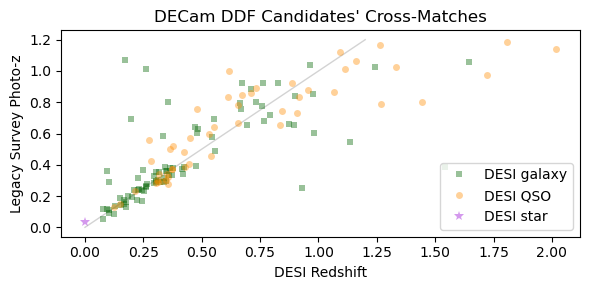

In [21]:
tx = np.where(lsdr10xm_meanpz[desi_xindex] >= 0.0)[0]
gx = np.where(desi_stype[tx] == 'GAL')[0]
qx = np.where(desi_stype[tx] == 'QSO')[0]
sx = np.where(desi_stype[tx] == 'STA')[0]

fig = plt.figure(figsize=(6, 3))
plt.plot([0, 1.2], [0, 1.2], ls='solid', lw=1, color='lightgrey')

plt.plot(desi_z[tx[gx]], lsdr10xm_meanpz[desi_xindex[tx[gx]]], 
         's', ms=5, alpha=0.4, mew=0, color='darkgreen', label='DESI galaxy')
plt.plot(desi_z[tx[qx]], lsdr10xm_meanpz[desi_xindex[tx[qx]]], 
         'o', ms=5, alpha=0.4, mew=0, color='darkorange', label='DESI QSO')
plt.plot(desi_z[tx[sx]], lsdr10xm_meanpz[desi_xindex[tx[sx]]], 
         '*', ms=7, alpha=0.4, mew=0, color='darkviolet', label='DESI star')
plt.legend(loc='lower right')
plt.ylabel('Legacy Survey Photo-z')
plt.xlabel('DESI Redshift')
plt.title("DECam DDF Candidates' Cross-Matches")

plt.tight_layout()
plt.savefig('desi_pz_comp')
plt.show()

del tx, gx, qx, sx

## Light curve parameters for DESI-matched objects

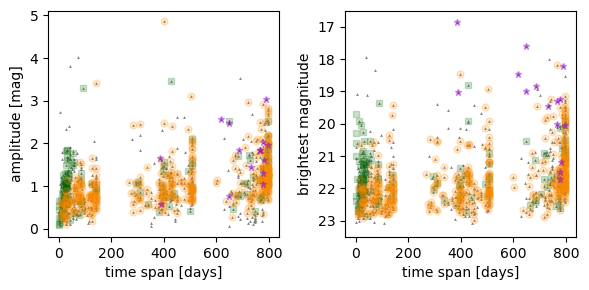

In [22]:
# fig, ax = plt.subplots(1, 3, figsize=(8, 6), sharex=False, sharey=False)
fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharex=False, sharey=False)

gx = np.where(desi_stype == 'GAL')[0]
qx = np.where(desi_stype == 'QSO')[0]
sx = np.where(desi_stype == 'STA')[0]

tx = np.where((paramLC_field == 'COSMOS') & (paramLC_tspan > 1))[0]
ax[0].plot(paramLC_tspan[tx], paramLC_amp[tx], '^', ms=2, mew=0, color='grey')
ax[0].plot(paramLC_tspan[desi_pindex[gx]], paramLC_amp[desi_pindex[gx]],
             's', ms=5, alpha=0.2, color='darkgreen', label='DESI galaxy')
ax[0].plot(paramLC_tspan[desi_pindex[qx]], paramLC_amp[desi_pindex[qx]],
              'o', ms=5, alpha=0.2, color='darkorange', label='DESI QSO')
ax[0].plot(paramLC_tspan[desi_pindex[sx]], paramLC_amp[desi_pindex[sx]],
              '*', ms=5, alpha=0.4, color='darkviolet', label='DESI star')
ax[0].set_xlabel('time span [days]')
ax[0].set_ylabel('amplitude [mag]')

ax[1].plot(paramLC_tspan[tx], paramLC_minmag[tx], '^', ms=2, mew=0, color='grey')
ax[1].plot(paramLC_tspan[desi_pindex[gx]], paramLC_minmag[desi_pindex[gx]],
              's', ms=5, alpha=0.2, color='darkgreen', label='DESI galaxy')
ax[1].plot(paramLC_tspan[desi_pindex[qx]], paramLC_minmag[desi_pindex[qx]],
              'o', ms=5, alpha=0.2, color='darkorange', label='DESI QSO')
ax[1].plot(paramLC_tspan[desi_pindex[sx]], paramLC_minmag[desi_pindex[sx]],
              '*', ms=5, alpha=0.4, color='darkviolet', label='DESI star')
ax[1].set_xlabel('time span [days]')
ax[1].set_ylabel('brightest magnitude')
ax[1].set_ylim([23.5, 16.5])

# ax[2].plot(paramLC_minmag, paramLC_amp, '^', ms=2, mew=0, color='grey')
# ax[2].plot(paramLC_minmag[desi_pindex[gx]], paramLC_amp[desi_pindex[gx]],
#               's', ms=5, alpha=0.2, color='darkgreen', label='DESI galaxy')
# ax[2].plot(paramLC_minmag[desi_pindex[qx]], paramLC_amp[desi_pindex[qx]],
#               'o', ms=5, alpha=0.2, color='darkorange', label='DESI QSO')
# ax[2].plot(paramLC_minmag[desi_pindex[sx]], paramLC_amp[desi_pindex[sx]],
#               '*', ms=5, alpha=0.2, color='darkviolet', label='DESI star')
# ax[2].set_xlabel('minmag')
# ax[2].set_ylabel('amp')

plt.tight_layout()
plt.savefig('desi_lc_comp')
plt.show()

Above: Can see that DECam DDF candidates cross matched with galaxies generally have shorter time spans, they're probably transients in hosts. Whereas those cross matched with stars or QSOs have longer time spans and, for the longer-duration events, larger amplitudes and brighter difference-image magnitudes (as expected for stars and QSOs).

In [23]:
# xx = np.where(lsdr10xm_candid == cand)[0]
# px = np.where(paramLC_candid == cand)[0]
# cx = np.where(candLC_candid == cand)[0]

Print some parameters for this candidate.

In [24]:
# print(lsdr10xm_candid[xx[0]], lsdr10xm_rmag[xx[0]])
# print(paramLC_field[px[0]], paramLC_candid[px[0]], paramLC_minmag_r[px[0]])
# print(' ')
# print('       %6s %6s %6s %6s ' % ('all', 'g', 'r', 'i'))
# print('tspan  %6.1f %6.1f %6.1f %6.1f' % (paramLC_tspan[px[0]], paramLC_tspan_g[px[0]], paramLC_tspan_r[px[0]], paramLC_tspan_i[px[0]]))
# print('minmag %6.1f %6.1f %6.1f %6.1f' % (paramLC_minmag[px[0]], paramLC_minmag_g[px[0]], paramLC_minmag_r[px[0]], paramLC_minmag_i[px[0]]))
# print('amp    %6.1f %6.1f %6.1f %6.1f' % (paramLC_amp[px[0]], paramLC_amp_g[px[0]], paramLC_amp_r[px[0]], paramLC_amp_i[px[0]]))
# print('neps   %6i %6i %6i %6i' % (paramLC_neps[px[0]], paramLC_neps_g[px[0]], paramLC_neps_r[px[0]], paramLC_neps_i[px[0]]))

Go with filter r because we have static-sky mags for filter r.

In [25]:
# usefilt = 'r'

Plot the difference-image light curve.

In [26]:
# fx = np.where(candLC_filter[cx] == usefilt)[0]
# days = candLC_mjd[cx[fx]]
# mags = candLC_mag[cx[fx]]

# x = np.where(all_filters == usefilt)[0]
# sym = all_fshapes[x[0]]
# clr = all_fcolors[x[0]]

# plt.figure(figsize=(4, 2))
# plt.plot(days, mags, sym, ms=3, color=clr)
# plt.gca().invert_yaxis()
# plt.show()

# del x, sym, clr

For RR Lyrae the periods are ~half a day, but Cepheids can be longer, ~10 days. 

Try 0.1 days to 20 days (even if the light curve above exhibits variability over a longer timescale).

In [27]:
# min_p = 0.1 * u.day
# max_p = 20.1 * u.day
# min_f = 1.0 / max_p
# max_f = 1.0 / min_p

Do the Lomb Scargle periodogram fit.

In [28]:
# frequency, power = LombScargle(days * u.day, mags).autopower(minimum_frequency=min_f, maximum_frequency=max_f)

In [29]:
# tmp = np.argsort(power)
# sx = tmp[::-1]
# best_period = 1 / frequency[sx[0]].value
# print('best period: ', best_period, ' in days')
# del tmp, sx

In [30]:
# print(np.min(power), np.max(power))
# print(np.mean(power), np.std(power))
# print((np.max(power)-np.mean(power))/np.std(power))

Show the results.

Take as the best period the highest power peak.

In [31]:
# plt.figure(figsize=(8, 2))
# plt.plot(frequency, power, color='grey', lw=1)
# plt.xlabel('frequency')
# plt.show()

# plt.figure(figsize=(8, 2))
# # plt.axvline(np.log10(best_period), color='dodgerblue', lw=5, alpha=0.5)
# # plt.plot(np.log10(1 / frequency.value), power, color='grey', lw=1)
# plt.axvline(best_period, color='dodgerblue', lw=5, alpha=0.5)
# plt.plot(1 / frequency.value, power, color='grey', lw=1)
# plt.xlabel('log period [days]')
# plt.show()

Phase-fold the light curve and plot it.

In [32]:
# t0 = np.min(days)
# days_norm = (days - t0) / best_period
# phase = np.mod(days_norm, 1.0)
# del t0

# x = np.where(all_filters == usefilt)[0]
# sym = all_fshapes[x[0]]
# clr = all_fcolors[x[0]]

# plt.figure(figsize=(4, 2))
# plt.plot(phase, mags, sym, ms=3, color=clr)
# plt.xlabel('phase')
# plt.gca().invert_yaxis()
# plt.show()

The above sequence of steps usually yeilds a best-fit period of a half day or a day.

This is just aliasing. It's not real! But it was a way to test doing periodograms.

Set the input parameters to go after longer duration variables.

https://www.aanda.org/articles/aa/full_html/2014/06/aa23252-13/F14.html

In [33]:
# # min_p = 50.0 * u.day
# # max_p = 1000.0 * u.day

# min_p = 30.0 * u.day
# max_p = 500.0 * u.day

# min_f = 1.0 / max_p
# max_f = 1.0 / min_p

Make the periodograms for all candidates matched to stars that have sufficient time span, amplitude, and number of epochs.

In [34]:
# min_tspan = 100
# min_amp = 0.5
# min_neps = 40

In [35]:
# t1 = time.time()

# for p in range(len(paramLC_candid)):

#     if (p == 10) | (p == 100) | (p == 1000):
#         t2 = time.time()
#         print('p=%6i, %5.1f seconds remain' % (p, ((t2-t1)/float(p))*(float(len(paramLC_candid)-p))))
    
#     if (lsdr10xm_flagstar[paramLC_xindex[p]] == 1) & \
#     (paramLC_tspan[p] > min_tspan) & (paramLC_amp[p] > min_amp) & \
#     (paramLC_neps[p] > min_neps):
#         tmp1 = np.zeros(3, dtype='float')
#         tmp2 = np.zeros(3, dtype='float')
#         tmp3 = np.zeros(3, dtype='float')

#         for f, filt in enumerate(all_filters):
#             x = np.where((candLC_candid == paramLC_candid[p]) & 
#                          (candLC_filter == filt))[0]

#             if len(x) > 30:
#                 days = candLC_mjd[x]
#                 mags = candLC_mag[x]
#                 frequency, power = LombScargle(days * u.day, mags).autopower(minimum_frequency=min_f, 
#                                                                              maximum_frequency=max_f)
#                 mx = np.argmax(power)
#                 tmp1[f] = 1 / frequency[mx].value
#                 tmp2[f] = (np.max(power)-np.mean(power))/np.std(power)
#                 tmp3[f] = np.max(power)
#                 del days, mags, frequency, power, mx
#             del x

#         paramLC_Pbest_g[p] = tmp1[0]
#         paramLC_Pbest_r[p] = tmp1[1]
#         paramLC_Pbest_i[p] = tmp1[2]
#         paramLC_Psnr_g[p] = tmp2[0]
#         paramLC_Psnr_r[p] = tmp2[1]
#         paramLC_Psnr_i[p] = tmp2[2]
#         paramLC_Ppwr_g[p] = tmp3[0]
#         paramLC_Ppwr_r[p] = tmp3[1]
#         paramLC_Ppwr_i[p] = tmp3[2]
#         del tmp1, tmp2
        
# t2 = time.time()
# print('elapsed: %5.1f' % (t2 - t1))
# del t1, t2

In [36]:
# gx = np.where(paramLC_Pbest_g > 0.0)[0]
# rx = np.where(paramLC_Pbest_r > 0.0)[0]
# ix = np.where(paramLC_Pbest_i > 0.0)[0]
# print(len(gx), len(rx), len(ix))
# del gx, rx, ix

Explore the periodogram results by plotting them.

In [37]:
# fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharex=False, sharey=False)

# gx = np.where(paramLC_Pbest_g > 0.0)[0]
# rx = np.where(paramLC_Pbest_r > 0.0)[0]
# ix = np.where(paramLC_Pbest_i > 0.0)[0]

# ax[0].hist(paramLC_Pbest_g[gx], bins=40, histtype='step', log=True, color=all_fcolors[0])
# ax[0].hist(paramLC_Pbest_r[rx], bins=40, histtype='step', log=True, color=all_fcolors[1])
# ax[0].hist(paramLC_Pbest_i[ix], bins=40, histtype='step', log=True, color=all_fcolors[2])
# ax[0].set_xlabel('best period')

# ax[1].hist(paramLC_Psnr_g[gx], bins=40, histtype='step', log=True, color=all_fcolors[0])
# ax[1].hist(paramLC_Psnr_r[rx], bins=40, histtype='step', log=True, color=all_fcolors[1])
# ax[1].hist(paramLC_Psnr_i[ix], bins=40, histtype='step', log=True, color=all_fcolors[2])
# ax[1].set_xlabel('best period "SNR"')

# ax[2].hist(paramLC_Ppwr_g[gx], bins=40, histtype='step', log=True, color=all_fcolors[0])
# ax[2].hist(paramLC_Ppwr_r[rx], bins=40, histtype='step', log=True, color=all_fcolors[1])
# ax[2].hist(paramLC_Ppwr_i[ix], bins=40, histtype='step', log=True, color=all_fcolors[2])
# ax[2].set_xlabel('best period power')

# plt.tight_layout()
# plt.show()

# del gx, rx, ix

In [38]:
# fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharex=False, sharey=False)

# gx = np.where(paramLC_Pbest_g > 0.0)[0]
# rx = np.where(paramLC_Pbest_r > 0.0)[0]
# ix = np.where(paramLC_Pbest_i > 0.0)[0]

# ax[0].plot(paramLC_Pbest_g[gx], paramLC_Psnr_g[gx], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[0])
# ax[0].plot(paramLC_Pbest_r[rx], paramLC_Psnr_r[rx], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[1])
# ax[0].plot(paramLC_Pbest_i[ix], paramLC_Psnr_i[ix], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[2])
# ax[0].set_xlabel('best period')
# ax[0].set_ylabel('best period "SNR"')

# ax[1].plot(paramLC_Pbest_g[gx], paramLC_Ppwr_g[gx], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[0])
# ax[1].plot(paramLC_Pbest_r[rx], paramLC_Ppwr_r[rx], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[1])
# ax[1].plot(paramLC_Pbest_i[ix], paramLC_Ppwr_i[ix], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[2])
# ax[1].set_xlabel('best period')
# ax[1].set_ylabel('best period power')

# ax[2].plot(paramLC_Psnr_g[gx], paramLC_Ppwr_g[gx], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[0])
# ax[2].plot(paramLC_Psnr_r[rx], paramLC_Ppwr_r[rx], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[1])
# ax[2].plot(paramLC_Psnr_i[ix], paramLC_Ppwr_i[ix], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[2])
# ax[2].set_xlabel('best period "SNR"')
# ax[2].set_ylabel('best period power')

# plt.tight_layout()
# plt.show()

# del gx, rx, ix

How often do the results from different filters agree?

In [39]:
# max_P = 365

# fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharex=False, sharey=False)

# grx = np.where((paramLC_Pbest_g > 0.0) & (paramLC_Pbest_r > 0.0) & 
#                (paramLC_Pbest_g < max_P) & (paramLC_Pbest_r < max_P))[0]
# rix = np.where((paramLC_Pbest_r > 0.0) & (paramLC_Pbest_i > 0.0) & 
#                (paramLC_Pbest_r < max_P) & (paramLC_Pbest_i < max_P))[0]
# gix = np.where((paramLC_Pbest_g > 0.0) & (paramLC_Pbest_i > 0.0) & 
#                (paramLC_Pbest_g < max_P) & (paramLC_Pbest_i < max_P))[0]
# del max_P

# ax[0].hist2d(paramLC_Pbest_r[grx], paramLC_Pbest_g[grx], bins=20, cmap='Greys')
# ax[0].set_xlabel('best period r')
# ax[0].set_ylabel('best period g')

# ax[1].hist2d(paramLC_Pbest_r[rix], paramLC_Pbest_i[rix], bins=20, cmap='Greys')
# ax[1].set_xlabel('best period r')
# ax[1].set_ylabel('best period i')

# ax[2].hist2d(paramLC_Pbest_i[gix], paramLC_Pbest_g[gix], bins=20, cmap='Greys')
# ax[2].set_xlabel('best period i')
# ax[2].set_ylabel('best period g')

# plt.tight_layout()
# plt.show()

# del grx, rix, gix

### Plot phase-folded light curves for periodic candidates

Check out a few of the best, with the highest snr and powers,
and periods less than the duration of the DDF to date.

In [40]:
# paramLC_Pbest_diffgr = np.abs(paramLC_Pbest_g - paramLC_Pbest_r)

# # min_pwr = 0.4
# # min_snr = 3.5
# # min_diff = 20
# # max_P = 800

# min_pwr = 0.4
# min_snr = 4.0
# min_diff = 20
# max_P = 365

# gx = np.where((paramLC_Ppwr_g > min_pwr) 
#               & (paramLC_Psnr_g > min_snr) 
#               & (paramLC_Pbest_g < max_P))[0]
# rx = np.where((paramLC_Ppwr_r > min_pwr) 
#               & (paramLC_Psnr_r > min_snr) 
#               & (paramLC_Pbest_r < max_P))[0]
# print('Number of candidates that have well fit best periods in g OR r: ', len(gx), len(rx))
# print(paramLC_candid[rx])
# del gx, rx

# print(' ')

# gx = np.where((paramLC_Ppwr_g > min_pwr) & (paramLC_Psnr_g > min_snr) 
#               & (paramLC_Pbest_g < max_P) & (paramLC_Pbest_diffgr < min_diff))[0]
# rx = np.where((paramLC_Ppwr_r > min_pwr) & (paramLC_Psnr_r > min_snr) 
#               & (paramLC_Pbest_r < max_P) & (paramLC_Pbest_diffgr < min_diff))[0]
# print('Number of candidates that have well fit periods in g and r that match: ', len(gx), len(rx))

# print(' ')

# print('Candidates to explore the r-band light curves & phase-folded light curves')
# print(paramLC_candid[rx])
# usecands = paramLC_candid[rx]
# del gx, rx

OK let's take a look at these.

In [41]:
# usefilt = 'r'
# for cand in usecands:
#     px = np.where(paramLC_candid == cand)[0]
#     if usefilt == 'g':
#         best_period = paramLC_Pbest_g[px[0]]
#     if usefilt == 'r':
#         best_period = paramLC_Pbest_r[px[0]]
#     if usefilt == 'i':
#         best_period = paramLC_Pbest_i[px[0]]
    
#     cx = np.where((candLC_candid == cand) & (candLC_filter == usefilt))[0]
#     days = candLC_mjd[cx]
#     mags = candLC_mag[cx]

#     x = np.where(all_filters == usefilt)[0]
#     sym = all_fshapes[x[0]]
#     clr = all_fcolors[x[0]]
    
#     fig, ax = plt.subplots(1, 2, figsize=(4, 1), sharex=False, sharey=True)
    
#     ax[0].plot(days, mags, sym, ms=3, color=clr)
#     ax[0].invert_yaxis()
#     ax[0].set_xlabel('mjd')

#     t0 = np.min(days)
#     days_norm = (days - t0) / best_period
#     phase = np.mod(days_norm, 1.0)

#     ax[1].plot(phase, mags, sym, ms=3, color=clr)
#     ax[1].set_xlabel('phase')
#     # ax[1].invert_yaxis()

#     ax[0].plot([t0, t0+best_period], [np.max(mags), np.max(mags)], lw=2, alpha=1, color='blue')
    
#     ax[0].set_title(paramLC_candid[px])
#     tmp = ''
#     if usefilt == 'g':
#         tmp += str(np.round(paramLC_Pbest_g[px[0]], 0))
#         tmp += ' ' + str(np.round(paramLC_Psnr_g[px[0]], 1))
#         tmp += ' ' + str(np.round(paramLC_Ppwr_g[px[0]], 1))
#     if usefilt == 'r':
#         tmp += str(np.round(paramLC_Pbest_r[px[0]], 0))
#         tmp += ' ' + str(np.round(paramLC_Psnr_r[px[0]], 1))
#         tmp += ' ' + str(np.round(paramLC_Ppwr_r[px[0]], 1))
#     if usefilt == 'i':
#         tmp += str(np.round(paramLC_Pbest_i[px[0]], 0))
#         tmp += ' ' + str(np.round(paramLC_Psnr_i[px[0]], 1))
#         tmp += ' ' + str(np.round(paramLC_Ppwr_i[px[0]], 1))
#     ax[1].set_title(tmp)

#     del px, cx, best_period, days, mags
#     del x, sym, clr
#     del t0, days_norm, phase
#     del tmp

Above we can see that even our best periodograms are probably just wrong.

Really need direct image magntidues, not just positive difference-image detections, to study stars.

### Plots for the varstars with faint tractor r-band mags